In [1]:
%pwd
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras import models, layers
from sklearn.metrics import confusion_matrix
import os
#you need to adjust the paths until it gets properly fixed, and run the labelling script for the mobifall.

In [2]:
%pwd

'D:\\TUDarmstadt\\DSII\\workspace\\fallDetection\\software\\notebooks'

In [3]:
%cd ..

D:\TUDarmstadt\DSII\workspace\fallDetection\software


In [4]:
%cd dataPreprocessing/

D:\TUDarmstadt\DSII\workspace\fallDetection\software\dataPreprocessing


In [5]:
from labellingData import readSubsCsvs
from normalizeData import normalizeDfCols
import matplotlib.pyplot as plt

In [6]:
%cd ..
%cd ..

D:\TUDarmstadt\DSII\workspace\fallDetection\software
D:\TUDarmstadt\DSII\workspace\fallDetection


In [7]:
absolutepath = 'D:/TUDarmstadt/DSII/workspace/fallDetection/dataSets/MobiFall_Dataset_v2.0_labelled\sub1'
df = readSubsCsvs(absolutepath)
df.head()

,timestamp,accelerometer_x,accelerometer_y,accelerometer_z,id,Name,Age,Height,Weight,Gender,fall
0,2318482693000,0.890643,-9.576807,-0.019154,1,sub1,32,180,85,Male,12
1,2318492108000,0.919373,-9.595961,-0.057461,1,sub1,32,180,85,Male,12
2,2318503365000,0.871489,-9.595961,-0.057461,1,sub1,32,180,85,Male,12
3,2318512831000,0.852336,-9.643845,-0.038307,1,sub1,32,180,85,Male,12
4,2318523222000,0.871489,-9.634268,-0.057461,1,sub1,32,180,85,Male,12


In [8]:
for col in df.columns:
    pctMissing = df[col].isnull().mean()
    print(f'{col} - {pctMissing :.1%}')

timestamp - 0.0%
accelerometer_x - 0.0%
accelerometer_y - 0.0%
accelerometer_z - 0.0%
id - 0.0%
Name - 0.0%
Age - 0.0%
Height - 0.0%
Weight - 0.0%
Gender - 0.0%
fall - 0.0%


In [9]:
fallRaw = df["fall"]
featuresRaw = df.drop(["fall", "id", "Name", "Age", "Height", "Weight", "Gender", "timestamp"], axis = 1)

In [10]:
featuresRaw.head()

,accelerometer_x,accelerometer_y,accelerometer_z
0,0.890643,-9.576807,-0.019154
1,0.919373,-9.595961,-0.057461
2,0.871489,-9.595961,-0.057461
3,0.852336,-9.643845,-0.038307
4,0.871489,-9.634268,-0.057461


In [11]:
scaler = MinMaxScaler()
numerical = ["accelerometer_x", "accelerometer_y", "accelerometer_z",]

In [12]:
featuresTransformed = pd.DataFrame(data = featuresRaw)
featuresTransformed[numerical] = scaler.fit_transform(featuresTransformed[numerical])
featuresTransformed.head()

,accelerometer_x,accelerometer_y,accelerometer_z
0,0.515679,0.251503,0.405026
1,0.516426,0.251002,0.403857
2,0.515182,0.251002,0.403857
3,0.514684,0.249749,0.404442
4,0.515182,0.250000,0.403857


In [13]:
y = fallRaw.values
labelEncoder = LabelEncoder()
yEncoded = labelEncoder.fit_transform(y)
y

array([12, 12, 12, ..., 14, 14, 14], dtype=int64)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(featuresTransformed.values, yEncoded, test_size = 0.2, random_state = 0)
print('Training set has {} samples'.format(x_train.shape))
print('Testing set has {} samples'.format(x_test.shape))

Training set has (7852, 3) samples
Testing set has (1964, 3) samples


In [15]:
x_trainReshaped = np.repeat(x_train[:, np.newaxis, :], 200, axis=1)
x_testReshaped = np.repeat(x_test[:, np.newaxis, :], 200, axis=1)

In [16]:
numClasses = len(np.unique(y))
y_trainCat = to_categorical(y_train, num_classes=numClasses)
y_testCat = to_categorical(y_test, num_classes=numClasses)

In [17]:
input = (200, 3)
model = models.Sequential()
model.add(layers.Conv1D(6, kernel_size=4, activation='relu', input_shape=input, padding='same'))

model.add(layers.MaxPooling1D(pool_size=4, strides=4))

model.add(layers.Conv1D(12, kernel_size=4, activation='relu',padding='same'))

model.add(layers.MaxPooling1D(pool_size=4, strides=4))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(numClasses, activation='softmax'))


In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 200, 6)            78        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 6)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 12)            300       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 12, 12)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                                                 
 dense (Dense)               (None, 128)               1

In [19]:
batch = 80
epochs = 40
iterationsPerEp = x_trainReshaped.shape[0] // batch

In [20]:
model.fit(x_trainReshaped, y_trainCat, batch_size=batch, epochs=epochs, steps_per_epoch=iterationsPerEp)

Epoch 1/40
98/98 [==============================] - 5s 38ms/step - loss: 1.1881 - accuracy: 0.4337
Epoch 2/40
98/98 [==============================] - 4s 40ms/step - loss: 0.7373 - accuracy: 0.7159
Epoch 3/40
98/98 [==============================] - 3s 34ms/step - loss: 0.5386 - accuracy: 0.8145
Epoch 4/40
98/98 [==============================] - 4s 38ms/step - loss: 0.4787 - accuracy: 0.8542
Epoch 5/40
98/98 [==============================] - 4s 38ms/step - loss: 0.4506 - accuracy: 0.8515
Epoch 6/40
98/98 [==============================] - 4s 40ms/step - loss: 0.4090 - accuracy: 0.8652
Epoch 7/40
98/98 [==============================] - 4s 40ms/step - loss: 0.3855 - accuracy: 0.8685
Epoch 8/40
98/98 [==============================] - 4s 39ms/step - loss: 0.3635 - accuracy: 0.8734
Epoch 9/40
98/98 [==============================] - 4s 39ms/step - loss: 0.3410 - accuracy: 0.8841
Epoch 10/40
98/98 [==============================] - 4s 40ms/step - loss: 0.3329 - accuracy: 0.8864
Epoch 11/

In [21]:
results = model.evaluate(x_testReshaped, y_testCat, batch_size=batch)

25/25 [==============================] - 0s 3ms/step - loss: 0.2224 - accuracy: 0.9027


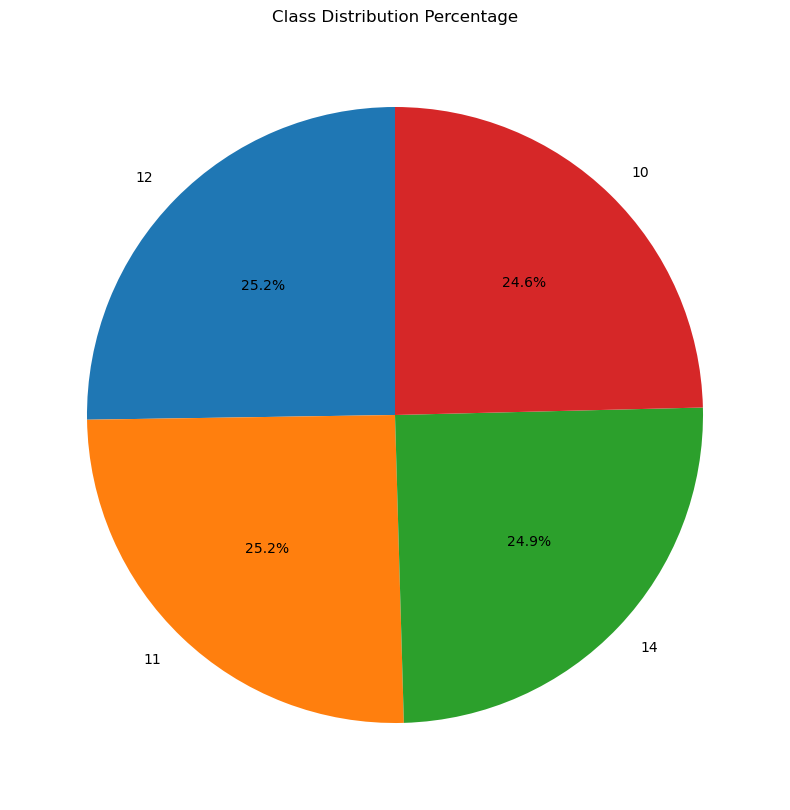

In [22]:

classDist = fallRaw.value_counts()
total = len(df)
percentage_distribution = (classDist / total) * 100

plt.figure(figsize= [10,10])
plt.pie(percentage_distribution, labels=percentage_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution Percentage')
plt.show()

In [23]:
predictions = model.predict(x_testReshaped)
predictions.shape

62/62 [==============================] - 0s 2ms/step
(1964, 4)


In [24]:
yTrueClasses = y_test
yPredClasses = np.argmax(predictions, axis=1)
confMat = confusion_matrix(yTrueClasses, yPredClasses)
confMat

array([[412,  80,   9,   4],
       [ 24, 472,   1,   1],
       [ 10,   3, 439,  21],
       [  2,   5,  31, 450]], dtype=int64)

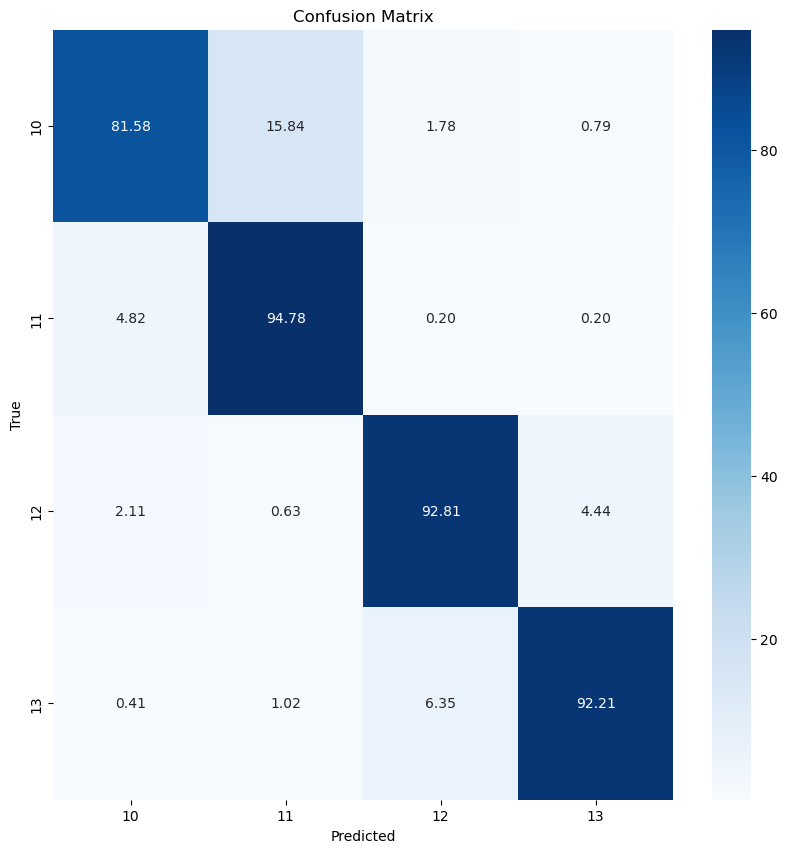

In [25]:
classes = ['10', '11', '12', '13']
plt.figure(figsize=[10,10])
confMatPerc = confMat.astype('float') / confMat.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(confMatPerc , annot=True, fmt='0.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()